In [30]:
import scipy.io
from scipy import sparse
import scipy.linalg
from scipy.sparse.linalg import inv

import pprint

import numpy as np

from matplotlib import pyplot as plt
import matplotlib

mat = scipy.io.loadmat("/home/alaa/Desktop/AER1513-State_Estimation/AER1513_State_Estimation/dataset1.mat")

#initialize all the data to variables
t = mat["t"]
r_k = mat["r"]
r_var = mat["r_var"]
u_k = mat["v"]
u_var = mat["v_var"]
x_c = mat["l"]
x_true = mat["x_true"]
size = len(x_true)



In [31]:
def rob_pos(delta = 1):
    #initlizing mathematical variables
    sampling_rate= 0.1
    sigma_q = u_var*sampling_rate**2
    sigma_r = r_var
    y_k = x_c - r_k
    v_k = u_k[1:]*sampling_rate
    size = len(y_k)
    h_top = np.eye(size)-np.diag(np.ones(size-1),-1)
    h_bottom = np.eye(size)
    x_0 = y_k[0]


    #creating correction matrix to zero out all the rows that are not multiples of delta
    if delta >1:
        block_diagonal = np.zeros(delta)
        block_diagonal[-1] = 1
        diagonal_matrix = np.diag(block_diagonal)
        delta_correction_matrix = np.kron(np.eye((size // block_diagonal.shape[0])+1), diagonal_matrix)
        delta_correction_matrix = delta_correction_matrix[0:size,0:size]
        y_k = (y_k.transpose()@delta_correction_matrix).transpose()
        h_bottom = h_bottom@delta_correction_matrix
        


    #setting up the vectors for the cholesky decomposition 
    z = np.concatenate(([x_0],v_k,y_k))

    h_matrix = np.concatenate((h_top,h_bottom))
    h_transpose = h_matrix.transpose()

    h_matrix = sparse.csr_matrix(h_matrix)
    h_transpose = sparse.csr_matrix(h_transpose)

    w_inverse_top = np.ones((1,size))/sigma_q
    w_inverse_bottom = np.ones((1,size))/sigma_r
    w_diag = np.concatenate([w_inverse_top,w_inverse_bottom],axis = 1)
    
    w_inverse_matrix = np.diag(w_diag[0])
    
    w_inverse_matrix = sparse.csr_matrix(w_inverse_matrix)

    #solving for the lhs and rhs matrices of the system 
    lhs_matrix = h_transpose@w_inverse_matrix@h_matrix
    rhs_matrix = h_transpose@w_inverse_matrix@z

    #solving for the Cholesky Decomposition
    lhs_matrix = lhs_matrix.toarray()
    L = scipy.linalg.cholesky(lhs_matrix, lower = True)

    L_transpose = L.transpose()

    #forward pass
    L = sparse.csr_matrix(L)
    d = sparse.linalg.spsolve(L,rhs_matrix)


    #backward pass
    L_transpose = sparse.csr_matrix(L_transpose)
    x_star = sparse.linalg.spsolve(L_transpose,d)

    lhs_matrix = sparse.csr_matrix(lhs_matrix)
    uncerEnv = np.sqrt(np.diag(sparse.linalg.spsolve(lhs_matrix,np.eye(size))))*3




    
    return [x_star, uncerEnv]

In [32]:
[x_star,uncerEnv] = rob_pos(1)


In [33]:
error = x_star-np.squeeze(x_true)

array([-0.01045412, -0.01040248, -0.01045678, ..., -0.16502179,
       -0.16499931, -0.1649766 ])

Delta: 1000, Avg Error: 0.06218951573640207


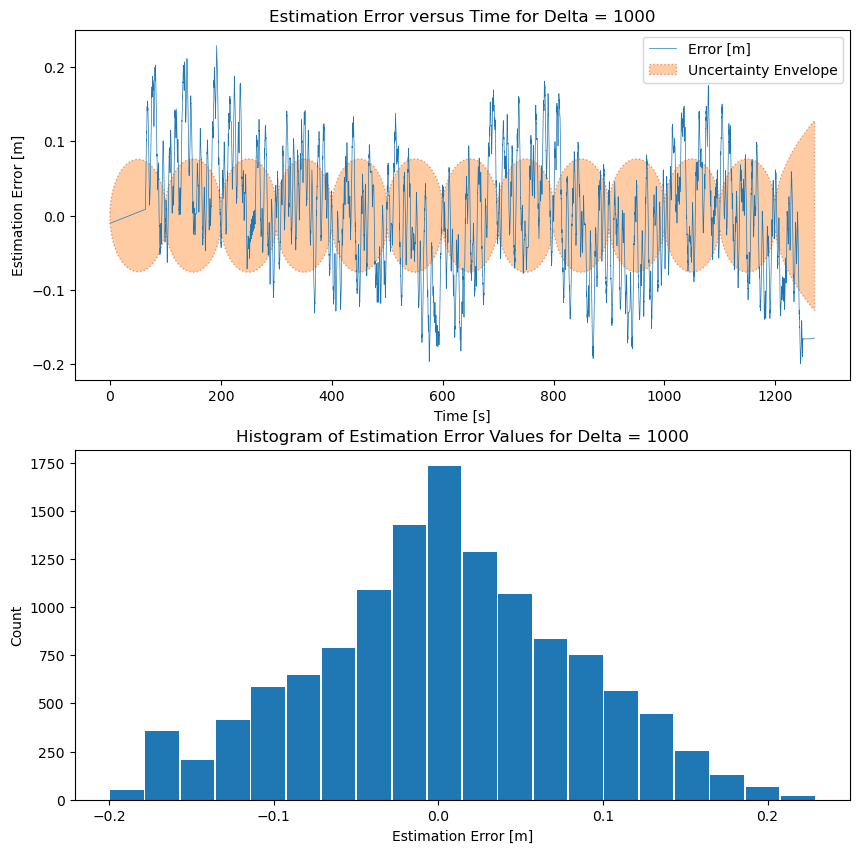

In [28]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
delta = 1


# Plot estimation error and uncertainty envelope
ax[0].plot(t, error, linewidth=0.5, label="Error [m]")
ax[0].fill_between(np.squeeze(t), -uncerEnv, +uncerEnv, edgecolor='#6b1bcc', facecolor='#bb87fa', alpha=0.5, linestyle=':', label='Uncertainty Envelope')
ax[0].set_title(f"Estimation Error versus Time for Delta = {delta}")
ax[0].set_ylabel("Estimation Error [m]")
ax[0].set_xlabel("Time [s]")
ax[0].legend(loc="upper right")

# Create a histogram of estimation error values
ax[1].hist(error, rwidth=0.95, bins=20)
ax[1].set_title(f"Histogram of Estimation Error Values for Delta = {delta}")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Estimation Error [m]")

# Save the figure
plt.savefig(f"delta{delta}.png")

# Print average error
avg_error = np.average(np.abs(error))
print(f"Delta: {delta}, Avg Error: {avg_error}")


In [37]:
sampling_rate= 0.1
sigma_q = u_var*sampling_rate**2
sigma_r = r_var
y_k = x_c - r_k
v_k = u_k[1:]*sampling_rate
size = len(y_k)
h_top = np.eye(size)-np.diag(np.ones(size-1),-1)
h_bottom = np.eye(size)
x_0 = y_k[0]

In [39]:
x_0[0]

0.9739731206506108

In [28]:
delta = 10
block_diagonal = np.zeros(delta)
block_diagonal[-1] = 1
diagonal_matrix = np.diag(block_diagonal)
delta_correction_matrix = np.kron(np.eye((size // block_diagonal.shape[0])+1), diagonal_matrix)
delta_correction_matrix = delta_correction_matrix[0:size,0:size]
y_k = (y_k.transpose()@delta_correction_matrix).transpose()
h_bottom = h_bottom@delta_correction_matrix


In [31]:
h_bottom

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#setting up the vectors for the cholesky decomposition 
z = np.concatenate(([x_],v_k,y_k))

h_matrix = np.concatenate((h_top,h_bottom))
h_transpose = h_matrix.transpose()

h_matrix = sparse.csr_matrix(h_matrix)
h_transpose = sparse.csr_matrix(h_transpose)

w_inverse_top = np.ones((1,size))/sigma_q
w_inverse_bottom = np.ones((1,size))/sigma_r
w_diag = np.concatenate([w_inverse_top,w_inverse_bottom],axis = 1)

w_inverse_matrix = np.diag(w_diag[0])


w_inverse_matrix = sparse.csr_matrix(w_inverse_matrix)

In [33]:
z

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
#solving for the lhs and rhs matrices of the system 
lhs_matrix = h_transpose@w_inverse_matrix@h_matrix
rhs_matrix = h_transpose@w_inverse_matrix@z

#solving for the Cholesky Decomposition
lhs_matrix = lhs_matrix.toarray()
L = scipy.linalg.cholesky(lhs_matrix, lower = True)

L_transpose = L.transpose()

In [ ]:

#forward pass
L = sparse.csr_matrix(L)
d = sparse.linalg.spsolve(L,rhs_matrix)